<h1>SIT307 Group Assignment 2 notebook - Feature Selection</h1>

<h3>Group 3</h3>
    Prepared by Roger Middenway, 217602784

# Imported libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
from scipy import stats
# import plotly.express as px
%matplotlib inline

from sklearn.metrics import cohen_kappa_score, roc_curve, f1_score, make_scorer

<h3> Preparing the dataframe

In [2]:
df = pd.read_csv('./data/healthcare-dataset-stroke-data.csv')

<h4>Tidying

In [3]:
##convert gender to lowercase
df['gender'] = df['gender'].apply(lambda x: x.lower())

# print(len(df[df['gender'] == 'other']))
## drop the one row that has "other" gender to keep things simple
df.drop(index=df[df['gender'] == 'other'].index, inplace=True)

##convert work_type to lowercase ensure consistent spacing 
df['work_type'] = df['work_type'].apply(lambda x: x.lower().replace('_','-'))

##convert residence_type to lowercase
df.rename(columns={'Residence_type':'residence_type'}, inplace=True)
df['residence_type'] = df['residence_type'].apply(lambda x: x.lower())

##convert smoking_status to lowercase ensure consistent spacing 
df['smoking_status'] = df['smoking_status'].apply(lambda x: x.lower().replace(' ', '-'))

## round off age
df['age'] = df['age'].apply(lambda x : round(x))

# cap BMI outliers to a maximum of 60 
df['bmi'] = df['bmi'].apply(lambda bmi_value: bmi_value if 12 < bmi_value < 60 else np.nan)

<h4>Imputing

In [4]:
m_df = df[df['gender'] == 'male']
f_df = df[df['gender'] == 'female']

m_bmi_avg = m_df.groupby('age')['bmi'].mean()
f_bmi_avg = f_df.groupby('age')['bmi'].mean()
##round to one to fit with other bmi values
m_bmi_avg = round(m_bmi_avg,1)
f_bmi_avg = round(f_bmi_avg,1)

missing_vals = df[df.isnull().any(axis = 1)]

for index, row in missing_vals.iterrows():
    if row['gender'] == 'male':
        df.loc[index,['bmi']] = m_bmi_avg[row['age']]
    else:
        df.loc[index,['bmi']] = f_bmi_avg[row['age']]

In [5]:
residence_type_map = {
    'urban':0,
    'rural':1
}
df['residence_type'] = df['residence_type'].map(residence_type_map)
# replace marital status with binary values
df['ever_married'] = df['ever_married'].str.lower().map({'yes': 1, 'no': 0})
# replace gender with binary values
df['gender'] = df['gender'].str.lower().map({'male': 1, 'female': 0})

<h4>Binning

In [6]:
# implement age bins
df['age_bin'] = pd.qcut(df['age'], q = 10, precision=1)

# implement glucose bins
df['avg_glucose_level_bin'] = pd.qcut(df['avg_glucose_level'], q=10, precision=1)

# implement bmi bins
df['bmi_bin'] = pd.qcut(df['bmi'], q=10, precision=1)

In [7]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_bin,avg_glucose_level_bin,bmi_bin
0,9046,1,67,0,1,1,private,0,228.69,36.6,formerly-smoked,1,"(65.0, 75.0]","(192.2, 271.7]","(34.2, 38.6]"
1,51676,0,61,0,0,1,self-employed,1,202.21,29.1,never-smoked,1,"(57.0, 65.0]","(192.2, 271.7]","(28.2, 29.9]"
2,31112,1,80,0,1,1,private,1,105.92,32.5,never-smoked,1,"(75.0, 82.0]","(98.9, 108.5]","(31.8, 34.2]"
3,60182,0,49,0,0,1,private,0,171.23,34.4,smokes,1,"(45.0, 51.0]","(124.1, 192.2]","(34.2, 38.6]"
4,1665,0,79,1,0,1,self-employed,1,174.12,24.0,never-smoked,1,"(75.0, 82.0]","(124.1, 192.2]","(22.6, 24.7]"


## Dummy dataset creation
SVM requires categorical attributes to be number encoded if they're ordinal, or dummy encoded if they aren't. That means smoking_status and work_type must be dummy encoded. As a starting point for feature selection, i dummy encoded all features.

In [8]:
def add_dummy(target_df, origin_df, col):
    abbrev = col[:2] + '_'
    for cat in origin_df[col].value_counts().index.tolist()[1:]:
        target_df[abbrev + str(cat)] = origin_df[col] == cat
        target_df[abbrev + str(cat)] = target_df[abbrev + str(cat)].map({False: 0, True: 1})


In [9]:
df_dummies = pd.DataFrame(index=df.index)

add_dummy(df_dummies, df, 'work_type')
add_dummy(df_dummies, df, 'smoking_status')
add_dummy(df_dummies, df, 'age_bin')
add_dummy(df_dummies, df, 'avg_glucose_level_bin')
add_dummy(df_dummies, df, 'bmi_bin')

In [10]:
to_add = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'residence_type', 'stroke']
df_dummies[to_add] = df[to_add]

In [11]:
df_dummies.head()

,wo_self-employed,wo_children,wo_govt-job,wo_never-worked,sm_unknown,sm_formerly-smoked,sm_smokes,"ag_(20.0, 30.0]","ag_(-0.1, 11.0]","ag_(30.0, 38.0]",...,"bm_(38.6, 59.7]","bm_(26.6, 28.2]","bm_(19.8, 22.6]","bm_(31.8, 34.2]",gender,hypertension,heart_disease,ever_married,residence_type,stroke
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,1,1,0,1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,1,1,1,1
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,1


## Preparing model for testing

In [12]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, RepeatedStratifiedKFold, cross_val_score, cross_validate
from IPython.display import clear_output
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [13]:
master_scores = {}
weights = {0:0.05, 1:1.0}
# model = SVC(gamma='scale', class_weight=weights)
metrics = ['f1', 'recall', 'roc_auc']

In [14]:
def test_feature_set(df, master_scores, description, model=SVC(C=5, kernel='linear', gamma='scale', class_weight=weights)):
    X = df.drop('stroke', axis=1)
    y = df['stroke']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=82)

    model.fit(X_train, y_train)

    y_true = y_test
    y_pred = model.predict(X_test)
    
    plot_confusion_matrix(model, X_test, y_test)
    print(classification_report(y_test, y_pred))
    
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)

    scores = cross_validate(model, X, y, scoring=['f1', 'recall', 'roc_auc'], cv=cv, n_jobs=-1)
    
    f1 = scores['test_f1'].mean()
    recall = scores['test_recall'].mean()
    roc = scores['test_roc_auc'].mean()
    
#     master_scores.append({description: (f1, recall, roc)})
    master_scores[description] = (f1, recall, roc)
    
    print(f'Mean f1: {f1}\nMean recall: {recall}\nMean roc: {roc}')

## Testing the base dummy encoded dataset

              precision    recall  f1-score   support

           0       0.99      0.63      0.77      1594
           1       0.12      0.89      0.21        92

    accuracy                           0.64      1686
   macro avg       0.56      0.76      0.49      1686
weighted avg       0.94      0.64      0.74      1686

Mean f1: 0.19785640741640115
Mean recall: 0.8503755102040818
Mean roc: 0.8076176702779877


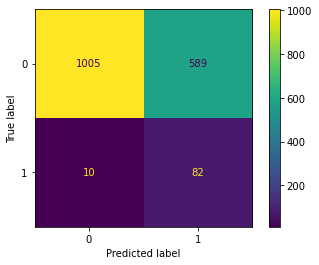

In [15]:
test_feature_set(df_dummies, master_scores, 'Dummy')

## Selecting features from the dummy encoded dataset
Using the same dummy encoded dataset, we'll select only the features we had identified as the most significant: age, average glucose level, hypertension and heart disease

In [16]:
selected_columns = ['ag_(20.0, 30.0]',
       'ag_(-0.1, 11.0]', 'ag_(30.0, 38.0]', 'ag_(38.0, 45.0]',
       'ag_(51.0, 57.0]', 'ag_(65.0, 75.0]', 'ag_(11.0, 20.0]',
       'ag_(75.0, 82.0]', 'ag_(45.0, 51.0]', 'av_(80.0, 85.6]',
       'av_(65.8, 73.8]', 'av_(192.2, 271.7]', 'av_(124.1, 192.2]',
       'av_(55.0, 65.8]', 'av_(108.5, 124.1]', 'av_(91.9, 98.9]',
       'av_(85.6, 91.9]', 'av_(73.8, 80.0]', 'hypertension', 'heart_disease', 'stroke']
df_dummies_pruned = df_dummies[selected_columns]

              precision    recall  f1-score   support

           0       0.99      0.63      0.77      1594
           1       0.12      0.89      0.21        92

    accuracy                           0.64      1686
   macro avg       0.56      0.76      0.49      1686
weighted avg       0.94      0.64      0.74      1686

Mean f1: 0.19768229231581547
Mean recall: 0.8499673469387755
Mean roc: 0.7752127697992777


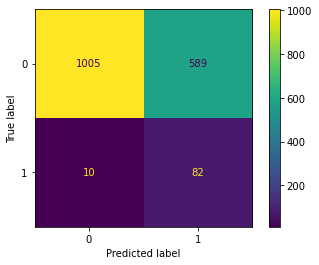

In [17]:
test_feature_set(df_dummies_pruned, master_scores, 'Dummy Selected')

## Mixed type dataset
SVM models, particularly python's SVC, are able to handle both binary and continuous data, as long as it's numerical. We will now test it with a dataset based on the identified relevant features as above, but we will change the age and avg_glucose_level features back to continuous, and normalise them using StandardScaler.

In [18]:
selected_columns = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'stroke']
df_mixed = df[selected_columns]
df_mixed_norm = df_mixed.copy(deep=True)

scaler = StandardScaler()
df_mixed_norm[['age', 'avg_glucose_level']] = scaler.fit_transform(df_mixed[['age', 'avg_glucose_level']])
df_mixed_norm.head()

,age,hypertension,heart_disease,avg_glucose_level,stroke
0,1.051238,0,1,2.706450,1
1,0.785886,0,0,2.121652,1
2,1.626168,0,1,-0.004867,1
3,0.255181,0,0,1.437473,1
4,1.581943,1,0,1.501297,1


              precision    recall  f1-score   support

           0       0.99      0.73      0.84      1594
           1       0.15      0.82      0.25        92

    accuracy                           0.73      1686
   macro avg       0.57      0.77      0.55      1686
weighted avg       0.94      0.73      0.81      1686

Mean f1: 0.22223349050468813
Mean recall: 0.8104979591836735
Mean roc: 0.8429039052658099


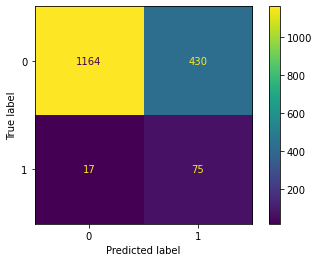

In [19]:
test_feature_set(df_mixed_norm, master_scores, 'Mixed Selected')

## Feature selection based on feature importance from Naive Bayes
This feature selection is taken from the 6 most likely and least likely dummy encoded features to be associated with the label, as found by a Naive Bayes model.

In [20]:
selected = ['ag_(75.0, 82.0]',
 'ag_(65.0, 75.0]',
 'av_(192.2, 271.7]',
 'hypertension',
 'heart_disease',
 'av_(124.1, 192.2]',
 'ag_(20.0, 30.0]',
 'ag_(-0.1, 11.0]',
 'ag_(30.0, 38.0]',
 'ag_(38.0, 45.0]',
 'av_(73.8, 80.0]',
 'av_(80.0, 85.6]',
 'stroke']

In [21]:
df_dummies_NB = df_dummies[selected]
df_dummies_NB.head()

,"ag_(75.0, 82.0]","ag_(65.0, 75.0]","av_(192.2, 271.7]",hypertension,heart_disease,"av_(124.1, 192.2]","ag_(20.0, 30.0]","ag_(-0.1, 11.0]","ag_(30.0, 38.0]","ag_(38.0, 45.0]","av_(73.8, 80.0]","av_(80.0, 85.6]",stroke
0,0,1,1,0,1,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,1,0,0,0,0,0,0,0,1
3,0,0,0,0,0,1,0,0,0,0,0,0,1
4,1,0,0,1,0,1,0,0,0,0,0,0,1


              precision    recall  f1-score   support

           0       0.98      0.81      0.89      1594
           1       0.18      0.72      0.28        92

    accuracy                           0.80      1686
   macro avg       0.58      0.76      0.59      1686
weighted avg       0.94      0.80      0.85      1686

Mean f1: 0.25098735657058446
Mean recall: 0.6632081632653062
Mean roc: 0.8073567817250357


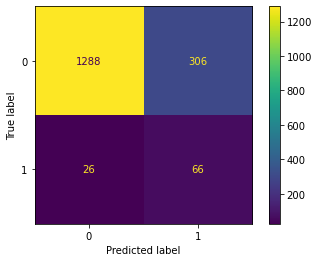

In [22]:
test_feature_set(df_dummies_NB, master_scores, 'NB Selected')

## Mixed dataset with MCA feature added

As this dataset is quite small and limited, we experimented with adding generated features, based on the existing ones. In this case, an Multiple Correspondence Analysis (MCA) was performed on the full discretised dataset (so continuous features were replaced with their binned variants). The coordinates derived from the MCA were added to the normalised mixed data type dataset.

In [23]:
import prince
mca_cols = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'residence_type', 'smoking_status', 'age_bin', 'avg_glucose_level_bin', 'bmi_bin']
df_mca = df[mca_cols]


In [24]:
mca = prince.MCA()
mca.fit(df_mca)
mca.transform(df_mca)

,0,1
0,-0.549744,-0.969813
1,-0.514676,-0.659104
2,-0.332229,-0.390999
3,-0.463019,0.089865
4,-0.378336,-0.334044
...,...,...
5105,-0.457917,-0.291389
5106,-0.488835,-0.488694
5107,-0.347462,-0.036607
5108,-0.270070,0.014020


In [25]:
df_mixed_mca = pd.merge(df_mixed_norm, mca.row_coordinates(df_mca), left_index=True, right_index=True)

              precision    recall  f1-score   support

           0       0.99      0.72      0.83      1594
           1       0.15      0.83      0.25        92

    accuracy                           0.73      1686
   macro avg       0.57      0.77      0.54      1686
weighted avg       0.94      0.73      0.80      1686

Mean f1: 0.21973363725879694
Mean recall: 0.8253387755102041
Mean roc: 0.8402350550096581


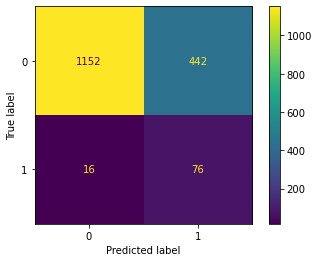

In [26]:
test_feature_set(df_mixed_mca, master_scores, 'Mixed with MCA')

## Testing based only on age and gender
In this dataset, age has by far the largest correlation with the label. In order to serve as a benchmark our other feature sets, a dataset was used which contained only the age and gender features.

In [27]:
df_age_gender = pd.DataFrame(df_mixed_norm[['age', 'stroke']])
df_age_gender['gender'] = df['gender']
df_age_gender.head()

,age,stroke,gender
0,1.051238,1,1
1,0.785886,1,0
2,1.626168,1,1
3,0.255181,1,0
4,1.581943,1,0


              precision    recall  f1-score   support

           0       0.98      0.73      0.84      1594
           1       0.14      0.80      0.25        92

    accuracy                           0.73      1686
   macro avg       0.56      0.77      0.54      1686
weighted avg       0.94      0.73      0.80      1686

Mean f1: 0.2158958340558315
Mean recall: 0.8257551020408164
Mean roc: 0.8335780633240952


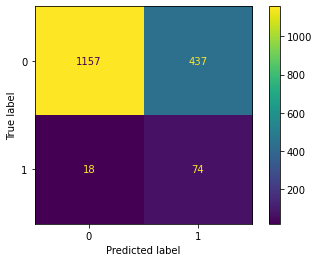

In [28]:
test_feature_set(df_age_gender, master_scores, 'Age and gender')

## Automated feature selection
Python has various algorithms for feature selection. The first is SelectKBest using chi2 as a measure, which will test the dependency between our features. This will be fed the normalised continuous features, and the dummy encoded discrete features.

In [29]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

In [30]:
df_full = pd.DataFrame()
to_copy1 = ['heart_disease', 'hypertension', 'gender', 'ever_married', 'residence_type', 'stroke']
df_full[to_copy1] = df[to_copy1]
to_copy2 = ['age', 'bmi', 'avg_glucose_level']
df_full[to_copy2] = df[to_copy2]
to_copy3 = ['wo_self-employed', 'wo_children', 'wo_govt-job', 'wo_never-worked', 'sm_unknown', 'sm_formerly-smoked', 'sm_smokes']
df_full[to_copy3] = df_dummies[to_copy3]
df_full[['mca0', 'mca1']] = df_mixed_mca[[0, 1]]

scaler = MinMaxScaler()
df_full[['age', 'avg_glucose_level', 'bmi', 'mca0', 'mca1']] = scaler.fit_transform(df_full[['age', 'avg_glucose_level', 'bmi', 'mca0', 'mca1']])
df_full.head()

,heart_disease,hypertension,gender,ever_married,residence_type,stroke,age,bmi,avg_glucose_level,wo_self-employed,wo_children,wo_govt-job,wo_never-worked,sm_unknown,sm_formerly-smoked,sm_smokes,mca0,mca1
0,1,0,1,1,0,1,0.817073,0.512658,0.801265,0,0,0,0,0,1,0,0.044480,0.114843
1,0,0,0,1,1,1,0.743902,0.354430,0.679023,1,0,0,0,0,0,0,0.055230,0.182544
2,1,0,1,1,1,1,0.975610,0.426160,0.234512,0,0,0,0,0,0,0,0.111160,0.240961
3,0,0,0,1,0,1,0.597561,0.466245,0.536008,0,0,0,0,0,0,1,0.071066,0.345737
4,0,1,0,1,1,1,0.963415,0.246835,0.549349,1,0,0,0,0,0,0,0.097026,0.253371


In [31]:
X = df_full.drop('stroke', axis=1)
y = df_full['stroke']

selector = SelectKBest(chi2, k=5)
selector.fit(X, y)
cols = selector.get_support(indices=True)
X_selected = X.iloc[:,cols]

## Resulting chi2 selected dataset
Selecting the 5 "best" features results in a dataset similar to the one we selected based on our analysis. The only differences are: the absence of avg_glucose level, and the inclusion of ever_married and wo_children - two features which intercorrelate strongly with age.

In [32]:
X_selected

,heart_disease,hypertension,ever_married,age,wo_children
0,1,0,1,0.817073,0
1,0,0,1,0.743902,0
2,1,0,1,0.975610,0
3,0,0,1,0.597561,0
4,0,1,1,0.963415,0
...,...,...,...,...,...
5105,0,1,1,0.975610,0
5106,0,0,1,0.987805,0
5107,0,0,1,0.426829,0
5108,0,0,1,0.621951,0


In [33]:
df_chi2_sel = X_selected.copy(deep=True)
df_chi2_sel['stroke'] = df_full['stroke']

              precision    recall  f1-score   support

           0       0.99      0.72      0.84      1594
           1       0.15      0.83      0.25        92

    accuracy                           0.73      1686
   macro avg       0.57      0.78      0.54      1686
weighted avg       0.94      0.73      0.80      1686

Mean f1: 0.2177304241136386
Mean recall: 0.803338775510204
Mean roc: 0.8396524817334342


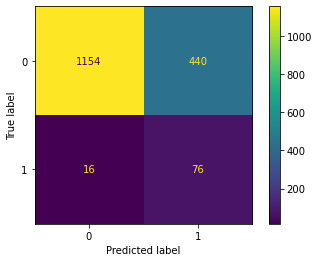

In [34]:
test_feature_set(df_chi2_sel, master_scores, 'Chi2 Selected')

## Recursive Feature Elimination Cross Validation (RFECV)
RFECV is another automated feature selection algorithm which selects the most useful features based on recursively removing them, and assessing the results based on a given estimator and desired metric. We will use this to estimate our most useful features, using an SVC model. We will do this twice: once using f1 as a metric, which will aim for a good balance of recall and precision; and using recall, which is of high priority in this context due to the medical nature of the machine learning problem.df


In [35]:
from sklearn.feature_selection import RFECV
X = df_full.drop('stroke', axis=1)
y = df_full['stroke']

estimator = SVC(gamma='scale', class_weight=weights, probability=True, kernel='linear')
selector = RFECV(estimator, step=1, cv=5, min_features_to_select=5, scoring='f1')
selector = selector.fit(X, y)

In [36]:
cols = selector.get_support(indices=True)
df_RFE_f1 = X.iloc[:,cols]
df_RFE_f1['stroke'] = df_full['stroke']

<ipython-input-36-00aec5f1fa66>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_RFE_f1['stroke'] = df_full['stroke']


## RFECV selection based on F1
This algorithm selected heart_disease, avg_glucose_level and age, just like the feature selection based on our initial analysis. However, it also selected smokes and formerly-smoked, which were also found to have slight correlations with stroke. 

In [37]:
df_RFE_f1.head()

,heart_disease,age,avg_glucose_level,wo_children,sm_formerly-smoked,sm_smokes,mca1,stroke
0,1,0.817073,0.801265,0,1,0,0.114843,1
1,0,0.743902,0.679023,0,0,0,0.182544,1
2,1,0.975610,0.234512,0,0,0,0.240961,1
3,0,0.597561,0.536008,0,0,1,0.345737,1
4,0,0.963415,0.549349,0,0,0,0.253371,1


              precision    recall  f1-score   support

           0       0.99      0.72      0.83      1594
           1       0.14      0.82      0.24        92

    accuracy                           0.73      1686
   macro avg       0.56      0.77      0.54      1686
weighted avg       0.94      0.73      0.80      1686

Mean f1: 0.21742197279684297
Mean recall: 0.8169387755102041
Mean roc: 0.8402474930713026


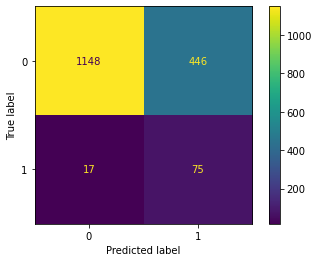

In [38]:
test_feature_set(df_RFE_f1, master_scores, 'RFE F1')

## RFECV selection based on recall
Finally, we'll repeat the RFECV process, using recall as a measure - keeping in mind that, for the purposes of identifying individuals at risk of stroke, maximising true positives may be vastly more important than reducing false positives.

In [39]:
X = df_full.drop('stroke', axis=1)
y = df_full['stroke']

estimator = SVC(gamma='scale', class_weight=weights, probability=True, kernel='linear')
selector = RFECV(estimator, step=1, cv=5, min_features_to_select=5, scoring='recall')
selector = selector.fit(X, y)

In [40]:
cols = selector.get_support(indices=True)
df_RFE_recall = X.iloc[:,cols]
df_RFE_recall['stroke'] = df_full['stroke']

<ipython-input-40-13f302e05723>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_RFE_recall['stroke'] = df_full['stroke']


## Selection based on recall
Interestingly, an RFECV based on recall selected 12 features, where the f1 metric resulted in only 7. Here we see features we had identified as relevant have been selected, along with others found to intercorrelate with age such as wo_children and ever_married.

In [41]:
df_RFE_recall.head()

,heart_disease,hypertension,ever_married,age,avg_glucose_level,wo_self-employed,wo_children,wo_govt-job,sm_unknown,sm_formerly-smoked,sm_smokes,mca1,stroke
0,1,0,1,0.817073,0.801265,0,0,0,0,1,0,0.114843,1
1,0,0,1,0.743902,0.679023,1,0,0,0,0,0,0.182544,1
2,1,0,1,0.975610,0.234512,0,0,0,0,0,0,0.240961,1
3,0,0,1,0.597561,0.536008,0,0,0,0,0,1,0.345737,1
4,0,1,1,0.963415,0.549349,1,0,0,0,0,0,0.253371,1


              precision    recall  f1-score   support

           0       0.99      0.72      0.83      1594
           1       0.15      0.83      0.25        92

    accuracy                           0.73      1686
   macro avg       0.57      0.77      0.54      1686
weighted avg       0.94      0.73      0.80      1686

Mean f1: 0.22187651941407455
Mean recall: 0.8305795918367346
Mean roc: 0.8411858822541362


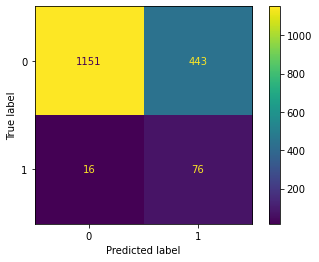

In [42]:
test_feature_set(df_RFE_recall, master_scores, 'RFE recall')

In [43]:
scores_df = pd.DataFrame(master_scores)

In [44]:
scores_df

,Dummy,Dummy Selected,Mixed Selected,NB Selected,Mixed with MCA,Age and gender,Chi2 Selected,RFE F1,RFE recall
0,0.197856,0.197682,0.222233,0.250987,0.219734,0.215896,0.217730,0.217422,0.221877
1,0.850376,0.849967,0.810498,0.663208,0.825339,0.825755,0.803339,0.816939,0.830580
2,0.807618,0.775213,0.842904,0.807357,0.840235,0.833578,0.839652,0.840247,0.841186


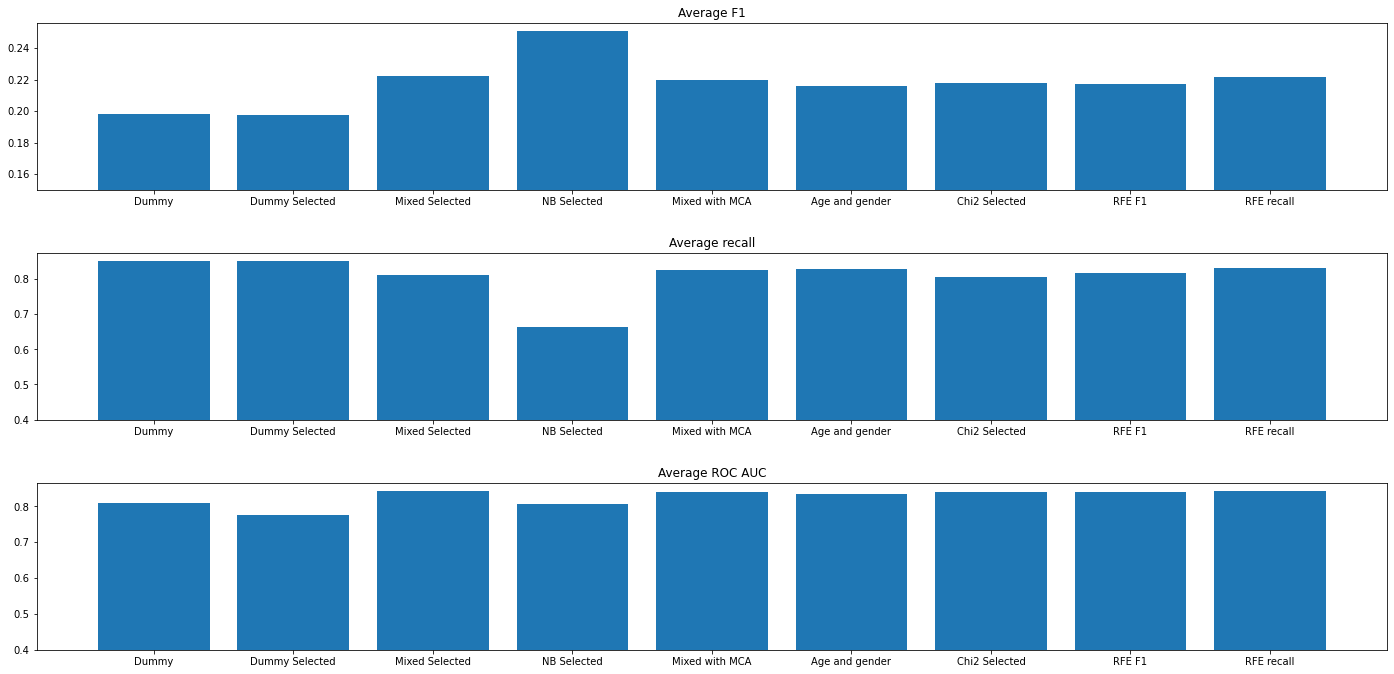

In [45]:
fig, ax = plt.subplots(3, figsize=(20,10))

# f1 = scores_df.iloc[[0]].values[0]

ax[0].bar(scores_df.columns, scores_df.iloc[[0]].values[0] - 0.15, bottom=0.15)
ax[0].set_title('Average F1')
ax[1].bar(scores_df.columns, scores_df.iloc[[1]].values[0] - 0.4, bottom=0.4)
ax[1].set_title('Average recall')
ax[2].bar(scores_df.columns, scores_df.iloc[[2]].values[0] - 0.4, bottom=0.4)
ax[2].set_title('Average ROC AUC')
fig.tight_layout(pad=3.0)
